In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline
def imshow(X, title=None, vmin=None, vmax=None, cmap=None, dpi=None):
    plt.figure(dpi=dpi)
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [4]:
Nz = 2**9
rho0_l = 0.2
rho0_s = 0.002

dz = 1/Nz
z = np.arange(Nz)

rhoH0 = 0.003
[Hz] = covariance.generate_circulant(Nz, dz, rhoH0,
                                   covariance.fft_sqd_exp_1d,
                                   return_Corr=True,
                                   return_eig=False)
Hz = Hz / Hz.sum(axis=0)[:, None]
# Hz = np.eye(Nz)[::2]

Ny = Hz.shape[0]
y = Hz @ z

coarse = 8
Nx = Nz // coarse
dx = dz * coarse
Sz2x = np.eye(Nz)[::coarse]
Sx2z = utilities.lin_interp_matrix(Nz, coarse)

Hx = Hz @ Sx2z
x = Sz2x @ z

l_max = 0.9
l_min = 0.2
var = 8 * Nz
zz = np.arange(Nz) - (Nz - 1)/2
D_l = 1 - np.exp(-(zz)**2/(2 * var))
D_l = (D_l - D_l.min())/(D_l.max() - D_l.min())
D_l = D_l * (l_max - l_min) + l_min
D_s = 1 - D_l
D_l = np.diag(np.sqrt(D_l))
D_s = np.diag(np.sqrt(D_s))

eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    Nz, dz, rho0_l, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    Nz, dz, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real

P_l_hetero = (D_l @ P_l @ D_l)
P_s_hetero = (D_s @ P_s @ D_s)

Pz = P_l_hetero + P_s_hetero
Lam_z, Qz = np.linalg.eigh(Pz)
Lam_z = Lam_z[::-1]
Qz = Qz[:, ::-1]

R_var = 0.1
R = R_var * np.eye(Ny)
trans_mats_true = assimilate.transformation_matrices(
    Hz, P=Pz,
    R=R, return_Ts=True)
for key, val in trans_mats_true.items():
    exec(key + 'z=val')
    
Px = Pz[::coarse, ::coarse]
Lam_x, Qx = np.linalg.eigh(Px)
Lam_x = Lam_x[::-1]
Qx = Qx[:, ::-1]
trans_mats_x = assimilate.transformation_matrices(
    Hx, P=Px,
    R=R, return_Ts=True)
for key, val in trans_mats_x.items():
    exec(key + 'x=val')

long variance:  1.000007453306344
short variance:  0.9987043816800435


In [5]:
dQxdt = np.gradient(Qx, axis=0)
d2Qxdt2 = np.gradient(dQxdt, axis=0)

/Users/harty/miniconda3/envs/loc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


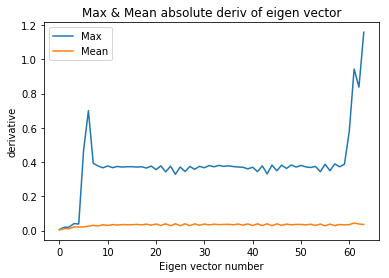

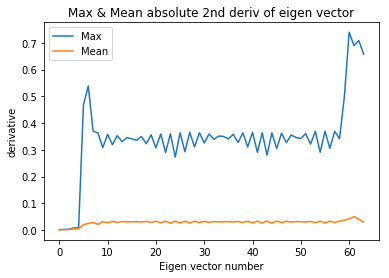

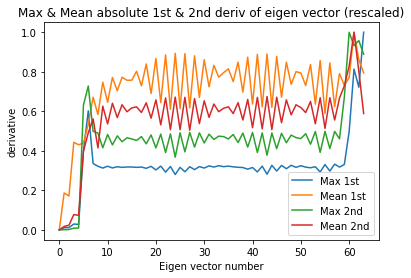

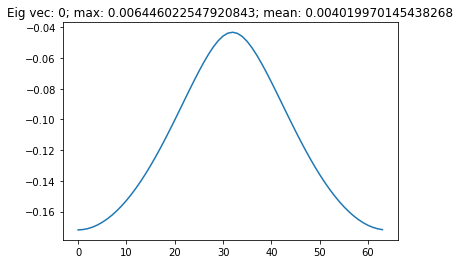

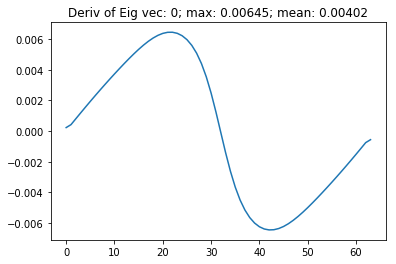

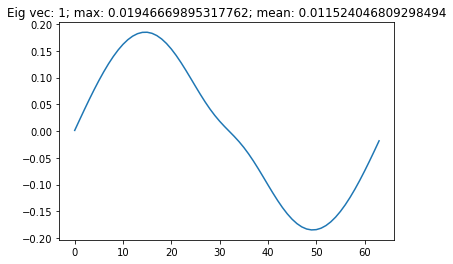

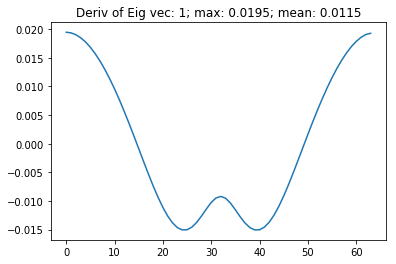

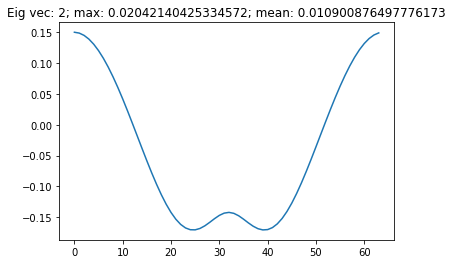

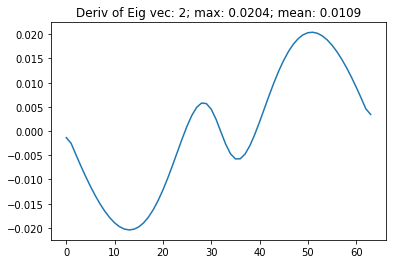

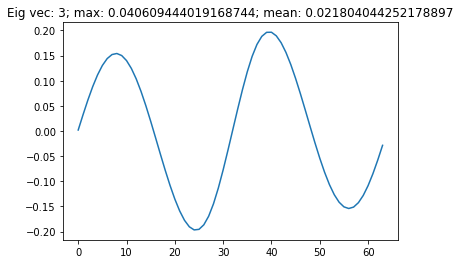

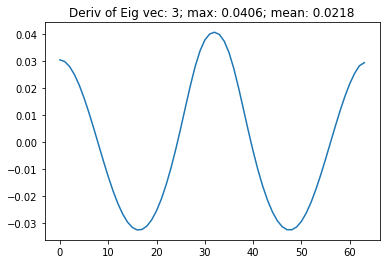

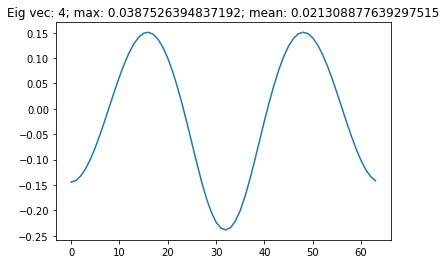

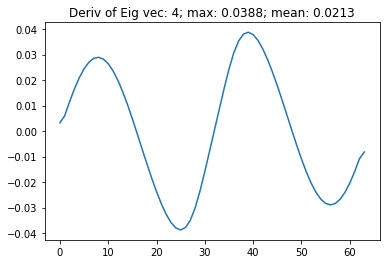

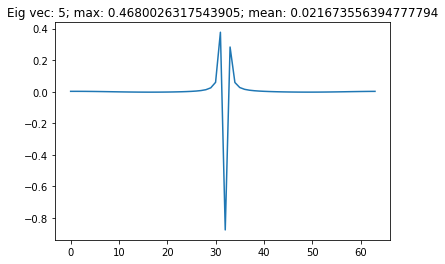

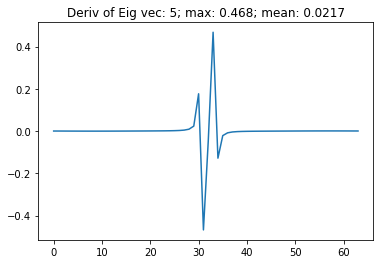

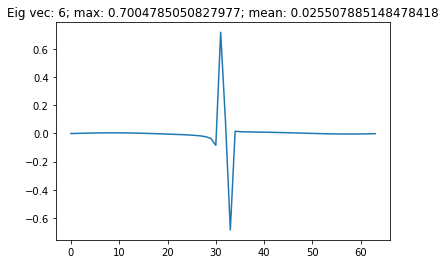

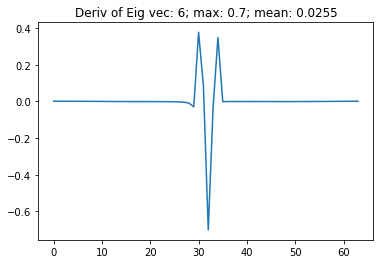

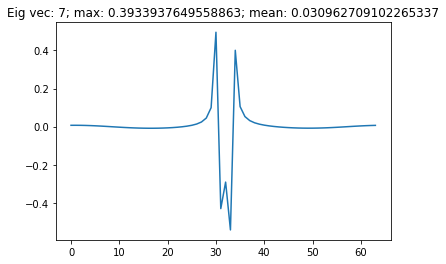

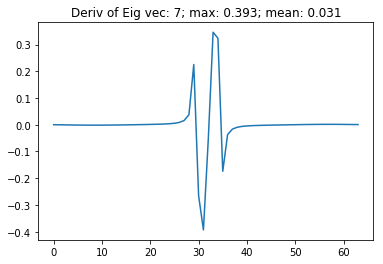

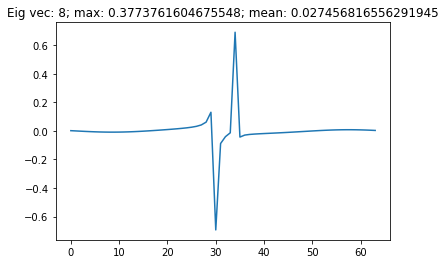

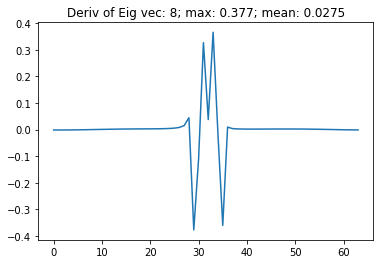

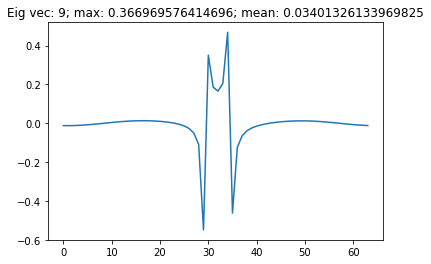

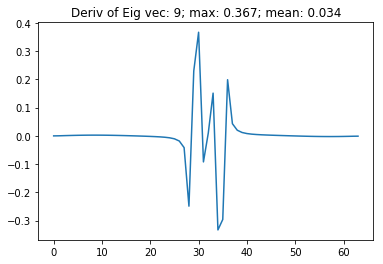

In [6]:
max_deriv = np.max(np.abs(dQxdt), axis=0)
mean_deriv = np.mean(np.abs(dQxdt), axis=0)
max_deriv2 = np.max(np.abs(d2Qxdt2), axis=0)
mean_deriv2 = np.mean(np.abs(d2Qxdt2), axis=0)
maxd_norm = (max_deriv - max_deriv.min())/(max_deriv.max() - max_deriv.min())
meand_norm = (mean_deriv - mean_deriv.min())/(mean_deriv.max() - mean_deriv.min())
maxd2_norm = (max_deriv2 - max_deriv2.min())/(max_deriv2.max() - max_deriv2.min())
meand2_norm = (mean_deriv2 - mean_deriv2.min())/(mean_deriv2.max() - mean_deriv2.min())

plt.figure()
plt.plot(max_deriv)
plt.plot(mean_deriv)
plt.title('Max & Mean absolute deriv of eigen vector')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max', 'Mean'])

plt.figure()
plt.plot(max_deriv2)
plt.plot(mean_deriv2)
plt.title('Max & Mean absolute 2nd deriv of eigen vector')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max', 'Mean'])

plt.figure()
plt.plot(maxd_norm)
plt.plot(meand_norm)
plt.plot(maxd2_norm)
plt.plot(meand2_norm)
plt.title('Max & Mean absolute 1st & 2nd deriv of eigen vector (rescaled)')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max 1st', 'Mean 1st',
            'Max 2nd', 'Mean 2nd'])

for ii in range(10):
    plt.figure()
    plt.plot(Qx[:, ii])
    plt.title(f'Eig vec: {ii}; max: {max_deriv[ii]}; mean: {mean_deriv[ii]}')
    
    plt.figure()
    plt.plot(dQxdt[:, ii])
    plt.title(f'Deriv of Eig vec: {ii}; max: {max_deriv[ii]:0.3}; mean: {mean_deriv[ii]:0.3}')

In [7]:
dQzdt = np.gradient(Qz, axis=0)
d2Qzdt2 = np.gradient(dQzdt, axis=0)

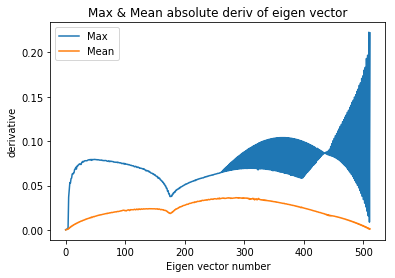

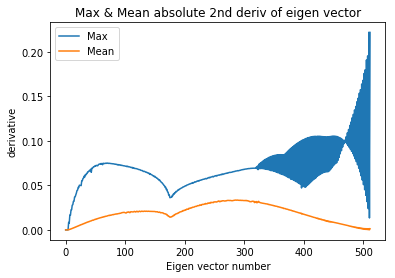

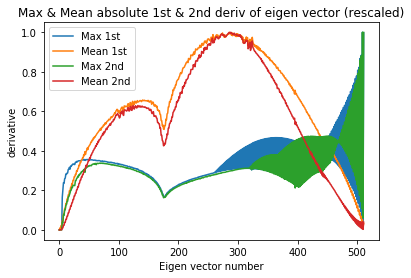

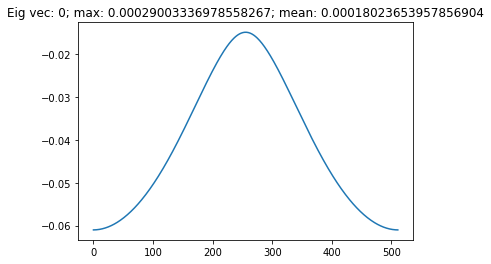

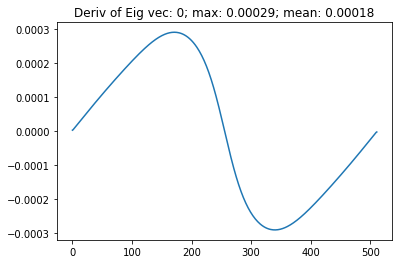

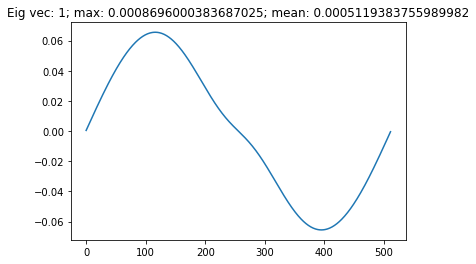

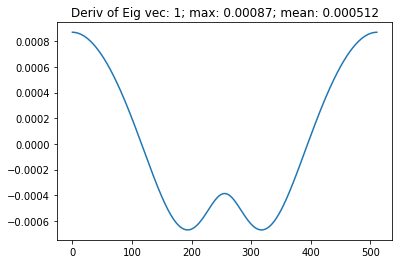

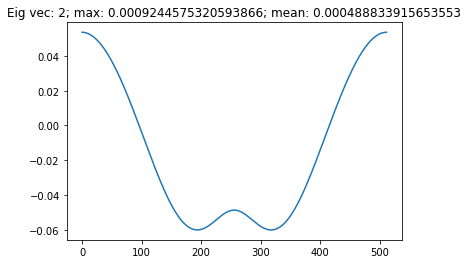

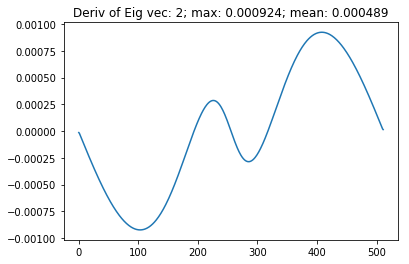

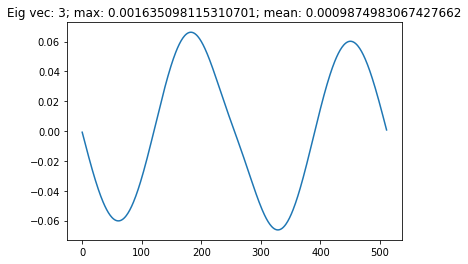

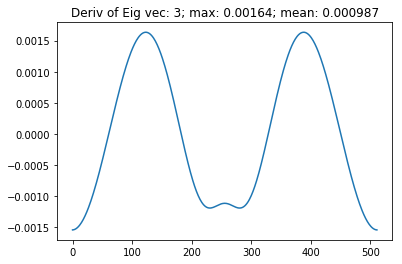

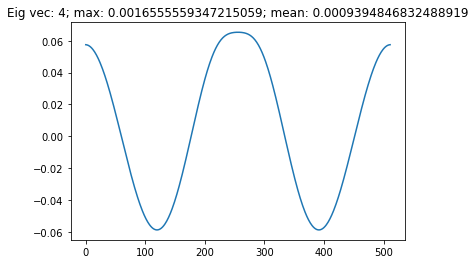

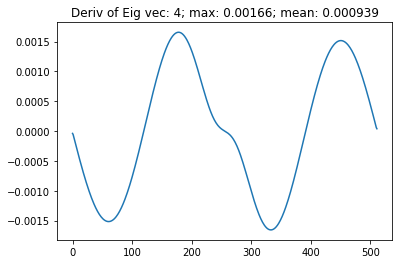

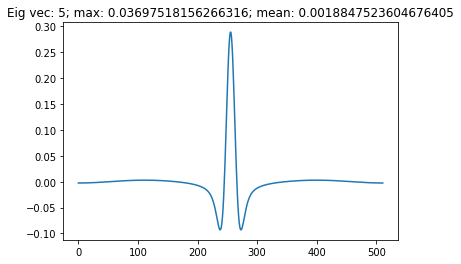

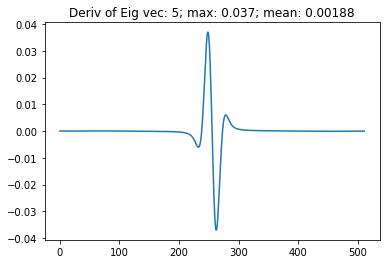

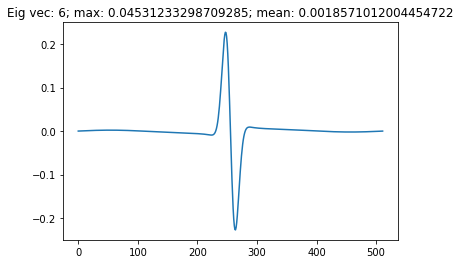

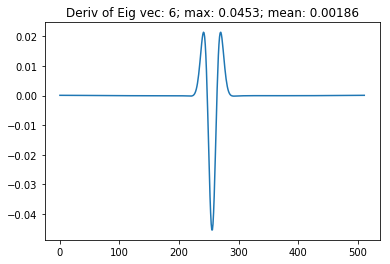

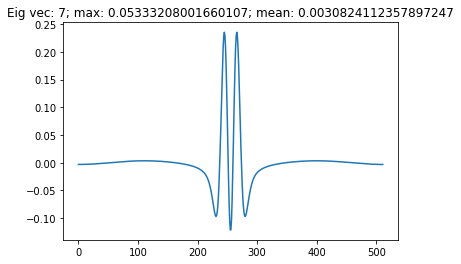

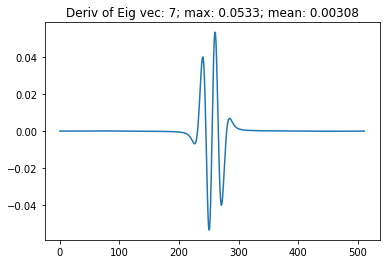

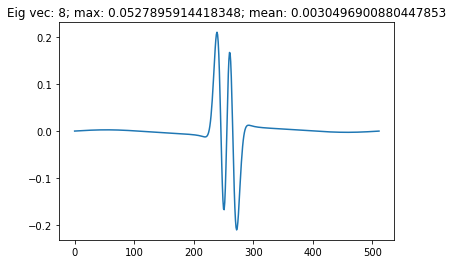

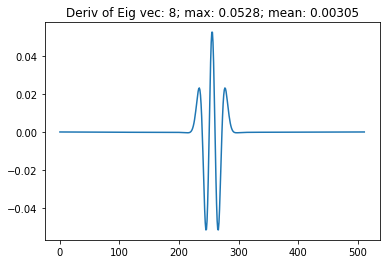

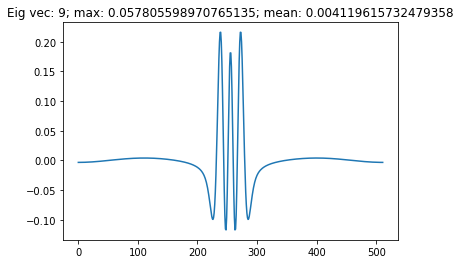

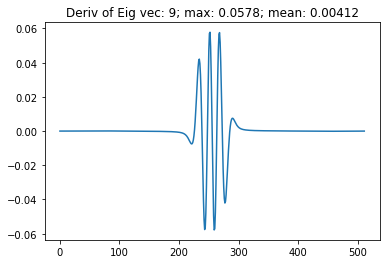

In [8]:
max_deriv = np.max(np.abs(dQzdt), axis=0)
mean_deriv = np.mean(np.abs(dQzdt), axis=0)
max_deriv2 = np.max(np.abs(d2Qzdt2), axis=0)
mean_deriv2 = np.mean(np.abs(d2Qzdt2), axis=0)
maxd_norm = (max_deriv - max_deriv.min())/(max_deriv.max() - max_deriv.min())
meand_norm = (mean_deriv - mean_deriv.min())/(mean_deriv.max() - mean_deriv.min())
maxd2_norm = (max_deriv2 - max_deriv2.min())/(max_deriv2.max() - max_deriv2.min())
meand2_norm = (mean_deriv2 - mean_deriv2.min())/(mean_deriv2.max() - mean_deriv2.min())

plt.figure()
plt.plot(max_deriv)
plt.plot(mean_deriv)
plt.title('Max & Mean absolute deriv of eigen vector')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max', 'Mean'])

plt.figure()
plt.plot(max_deriv2)
plt.plot(mean_deriv2)
plt.title('Max & Mean absolute 2nd deriv of eigen vector')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max', 'Mean'])

plt.figure()
plt.plot(maxd_norm)
plt.plot(meand_norm)
plt.plot(maxd2_norm)
plt.plot(meand2_norm)
plt.title('Max & Mean absolute 1st & 2nd deriv of eigen vector (rescaled)')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max 1st', 'Mean 1st',
            'Max 2nd', 'Mean 2nd'])

for ii in range(10):
    plt.figure()
    plt.plot(Qz[:, ii])
    plt.title(f'Eig vec: {ii}; max: {max_deriv[ii]}; mean: {mean_deriv[ii]}')
    
    plt.figure()
    plt.plot(dQzdt[:, ii])
    plt.title(f'Deriv of Eig vec: {ii}; max: {max_deriv[ii]:0.3}; mean: {mean_deriv[ii]:0.3}')

In [9]:
N_lam1 = 5
Q1 = Qz[:, :N_lam1]
Lam1 = Lam_z[:N_lam1]
Lam1f = Lam_z.copy()
Lam1f[N_lam1:] = 0

tot_per = 99
per_lam = Lam_z.cumsum()/Lam_z.sum()*100
N_lam_tot = np.abs(per_lam - tot_per).argmin()

# N_lam2 = Nz - N_lam1
N_lam2 = N_lam_tot - N_lam1
Q2 = Qz[:, N_lam1:N_lam1 + N_lam2]
Lam2 = Lam_z[N_lam1:N_lam1 + N_lam2]
Lam2f = Lam_z.copy()
Lam2f[:N_lam1] = 0
Lam2f[N_lam1 + N_lam2:] = 0

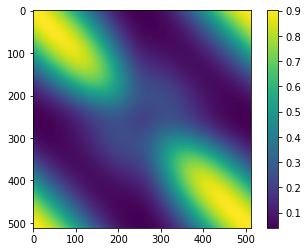

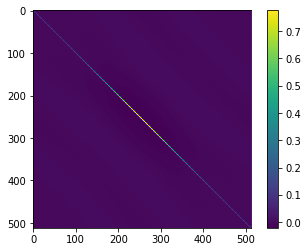

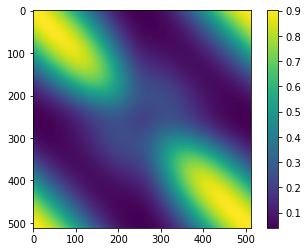

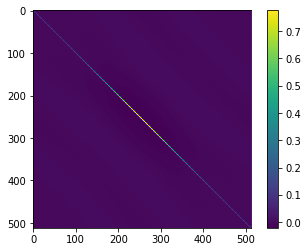

In [10]:
imshow(Qz @ np.diag(Lam1f) @ Qz.T)
imshow(Qz @ np.diag(Lam2f) @ Qz.T)

imshow(Q1 @ np.diag(Lam1) @ Q1.T)
imshow(Q2 @ np.diag(Lam2) @ Q2.T)

In [11]:
U1, s1, VT1 = np.linalg.svd(R_inv_sqrtz @ Hz @ Q1 @ np.diag(Lam1**(1/2)), full_matrices=False)
S1 = np.diag(s1)
U2, s2, VT2 = np.linalg.svd(R_inv_sqrtz @ Hz @ Q2 @ np.diag(Lam2**(1/2)), full_matrices=False)
S2 = np.diag(s2)

0.00028970019833726365
2.616252458475391e-06
0.017721986358120397
0.00017734394816116704


Text(0, 0.5, 'Inner product')

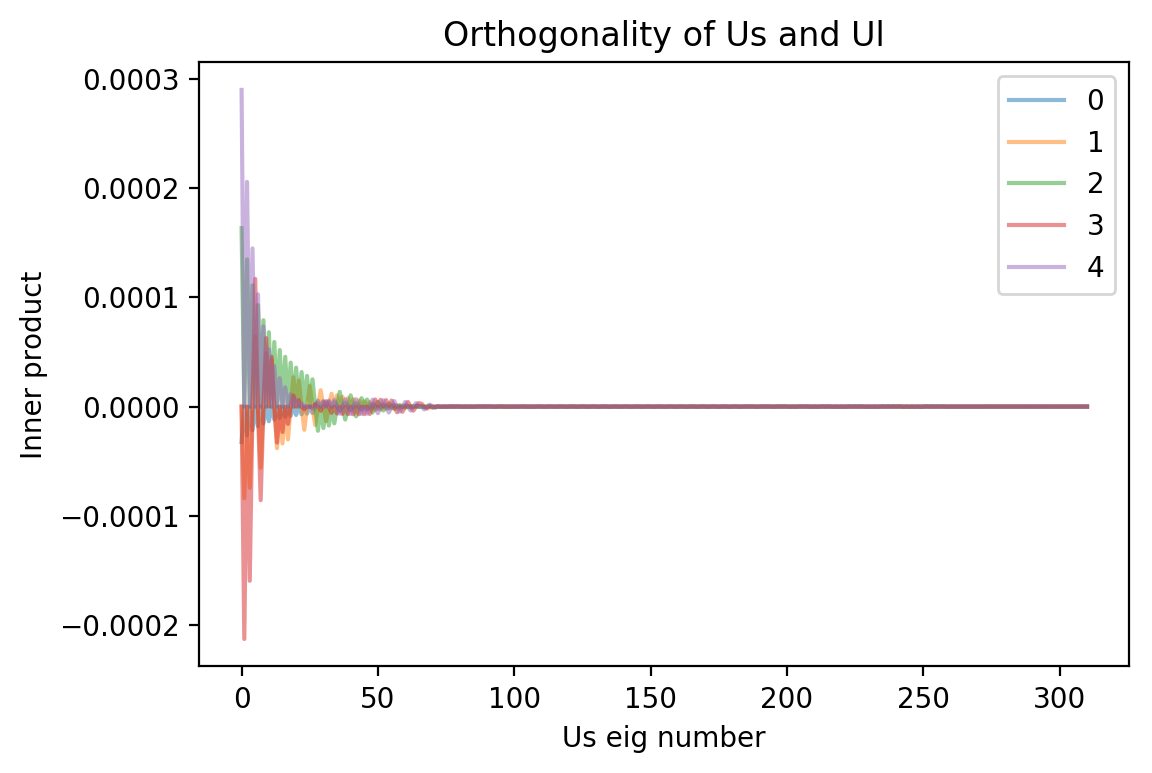

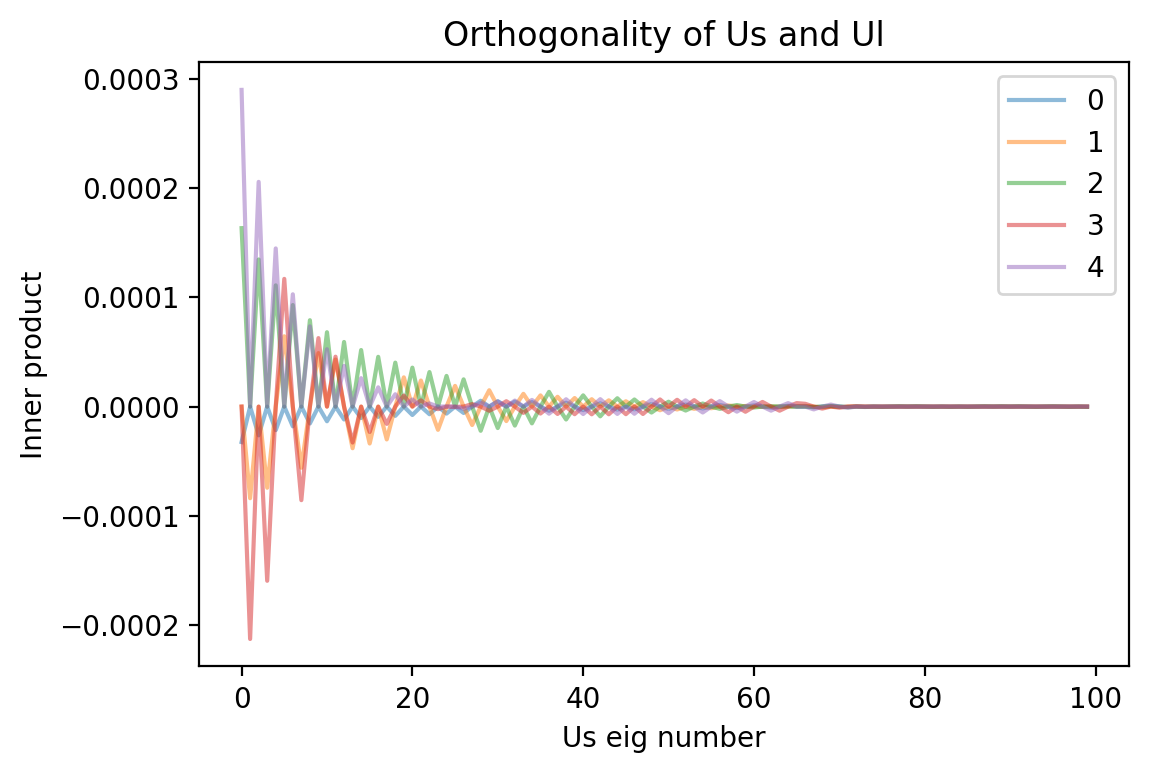

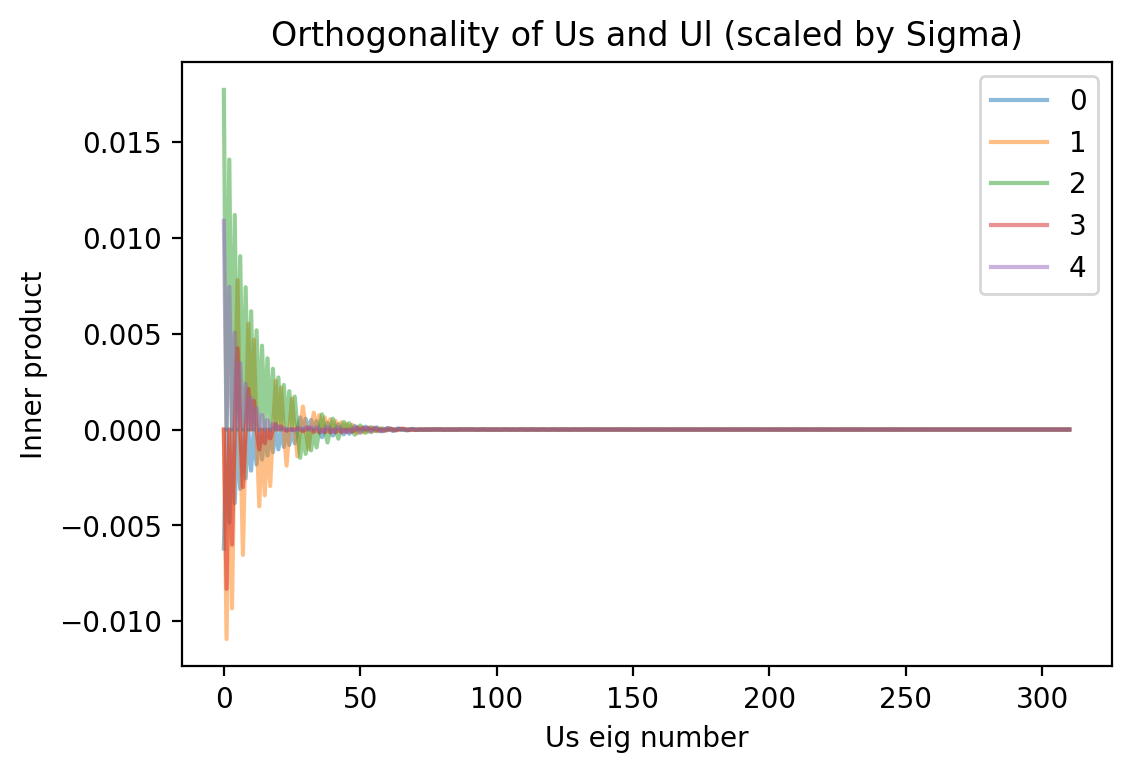

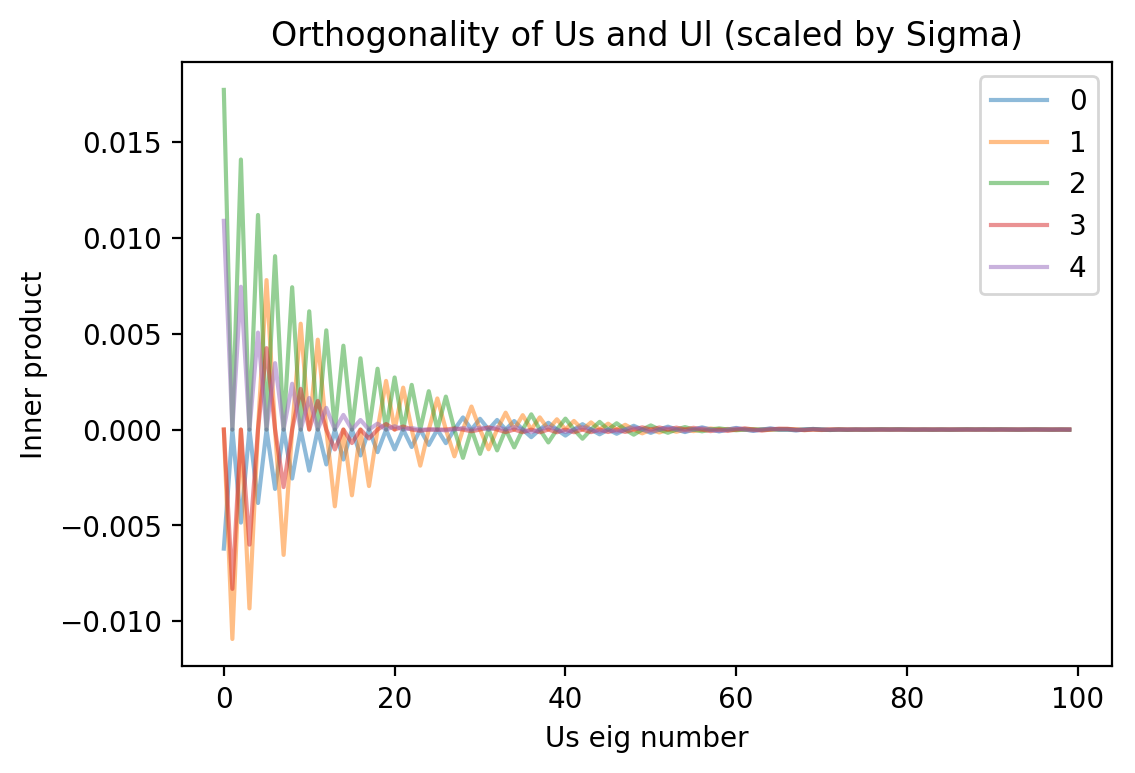

In [12]:
Uprod = (U1.T @ U2)
print(np.abs(Uprod).max())
print(np.abs(Uprod).mean())

plt.figure(dpi=200)
plt.plot(Uprod.T, alpha=0.5)
plt.legend(np.arange(U1.shape[1]))
plt.title('Orthogonality of Us and Ul')
plt.xlabel('Us eig number')
plt.ylabel('Inner product')

plt.figure(dpi=200)
plt.plot(Uprod[:, :100].T, alpha=0.5)
plt.legend(np.arange(U1.shape[1]))
plt.title('Orthogonality of Us and Ul')
plt.xlabel('Us eig number')
plt.ylabel('Inner product')

Uprod = (S1 @ U1.T @ U2 @ S2)
print(np.abs(Uprod).max())
print(np.abs(Uprod).mean())

plt.figure(dpi=200)
plt.plot(Uprod.T, alpha=0.5)
plt.legend(np.arange(U1.shape[1]))
plt.title('Orthogonality of Us and Ul (scaled by Sigma)')
plt.xlabel('Us eig number')
plt.ylabel('Inner product')

plt.figure(dpi=200)
plt.plot(Uprod[:, :100].T, alpha=0.5)
plt.legend(np.arange(U1.shape[1]))
plt.title('Orthogonality of Us and Ul (scaled by Sigma)')
plt.xlabel('Us eig number')
plt.ylabel('Inner product')

In [13]:
U1f, s1f, VT1f = np.linalg.svd(R_inv_sqrtz @ Hz @ Qz @ np.diag(Lam1f**(1/2)), full_matrices=False)
S1f = np.diag(s1f)
U2f, s2f, VT2f = np.linalg.svd(R_inv_sqrtz @ Hz @ Qz @ np.diag(Lam2f**(1/2)), full_matrices=False)
S2f = np.diag(s2f)

In [14]:
Uprod = (U1f[:, :N_lam1].T @ U2f[:, :N_lam2])
print(np.abs(Uprod).max())
print(np.abs(Uprod).mean())
Vprod = (VT1f[:N_lam1] @ VT2f[:N_lam2].T)
print(np.abs(Vprod).max())
print(np.abs(Vprod).mean())

0.0002897001983371509
2.6162524584980104e-06
4.886518194692482e-13
2.385140373226844e-15


In [15]:
Tx1 = VT1 @ np.diag(Lam1**(-1/2)) @ Q1.T
Tx1R = Q1 @ np.diag(Lam1**(1/2)) @ VT1.T
Ty1 = U1.T @ R_inv_sqrtz
Ty1R = R_sqrtz @ U1

Tx2 = VT2 @ np.diag(Lam2**(-1/2)) @ Q2.T
Tx2R = Q2 @ np.diag(Lam2**(1/2)) @ VT2.T
Ty2 = U2.T @ R_inv_sqrtz
Ty2R = R_sqrtz @ U2

In [16]:
Ty_prod = Ty1 @ Ty2.T
print(np.abs(Ty_prod).max())
print(np.abs(Ty_prod).mean())

0.002897001983372449
2.616252458475803e-05


In [17]:
Tp1 = R_inv_sqrtz @ Hz @ Q1 @ np.diag(Lam1**(1/2))
Tp2 = R_inv_sqrtz @ Hz @ Q2 @ np.diag(Lam2**(1/2))

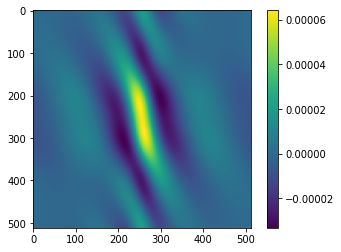

In [18]:
this = Q1 @ Q1.T @ Hz.T @ np.eye(R.shape[0]) / R_var @ Hz @ Q2 @ Q2.T
a_mu = np.random.multivariate_normal(np.ones(Nz), Pz)
imshow(this)

In [19]:
Proj = np.eye(Nz) - Q1 @ Q1.T - Q2 @ Q2.T

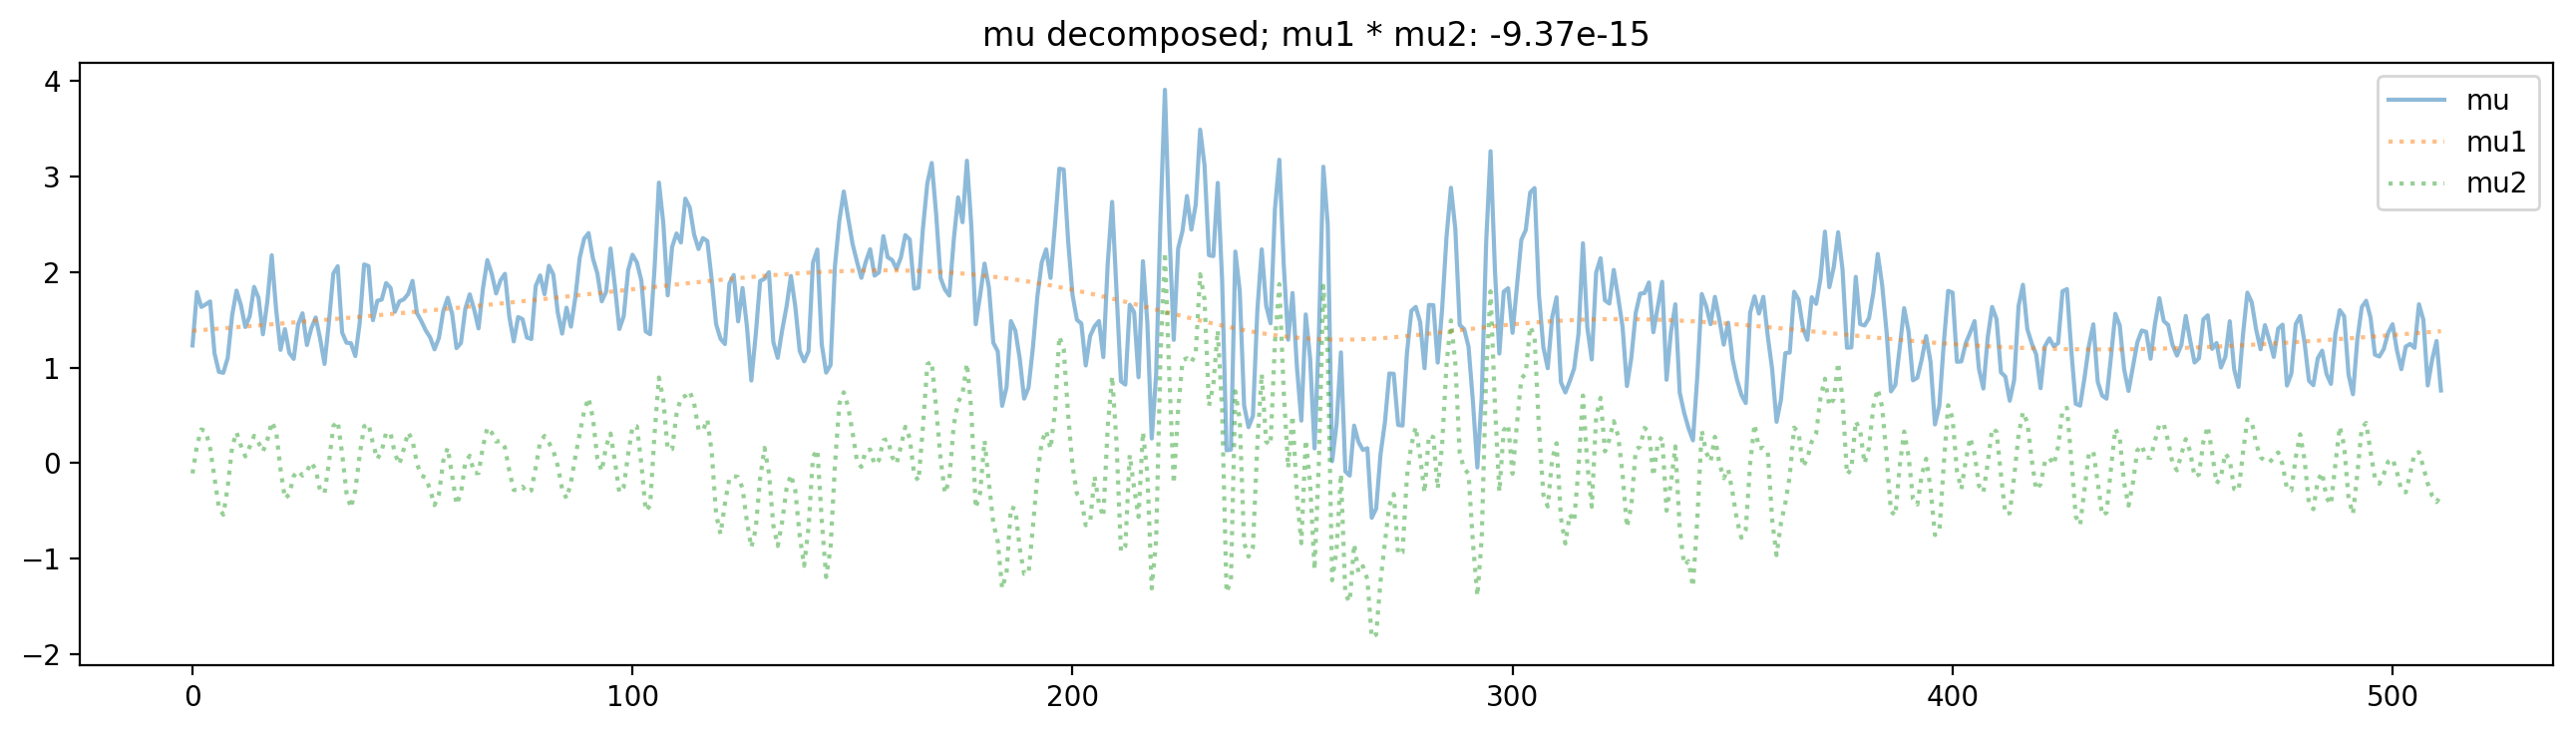

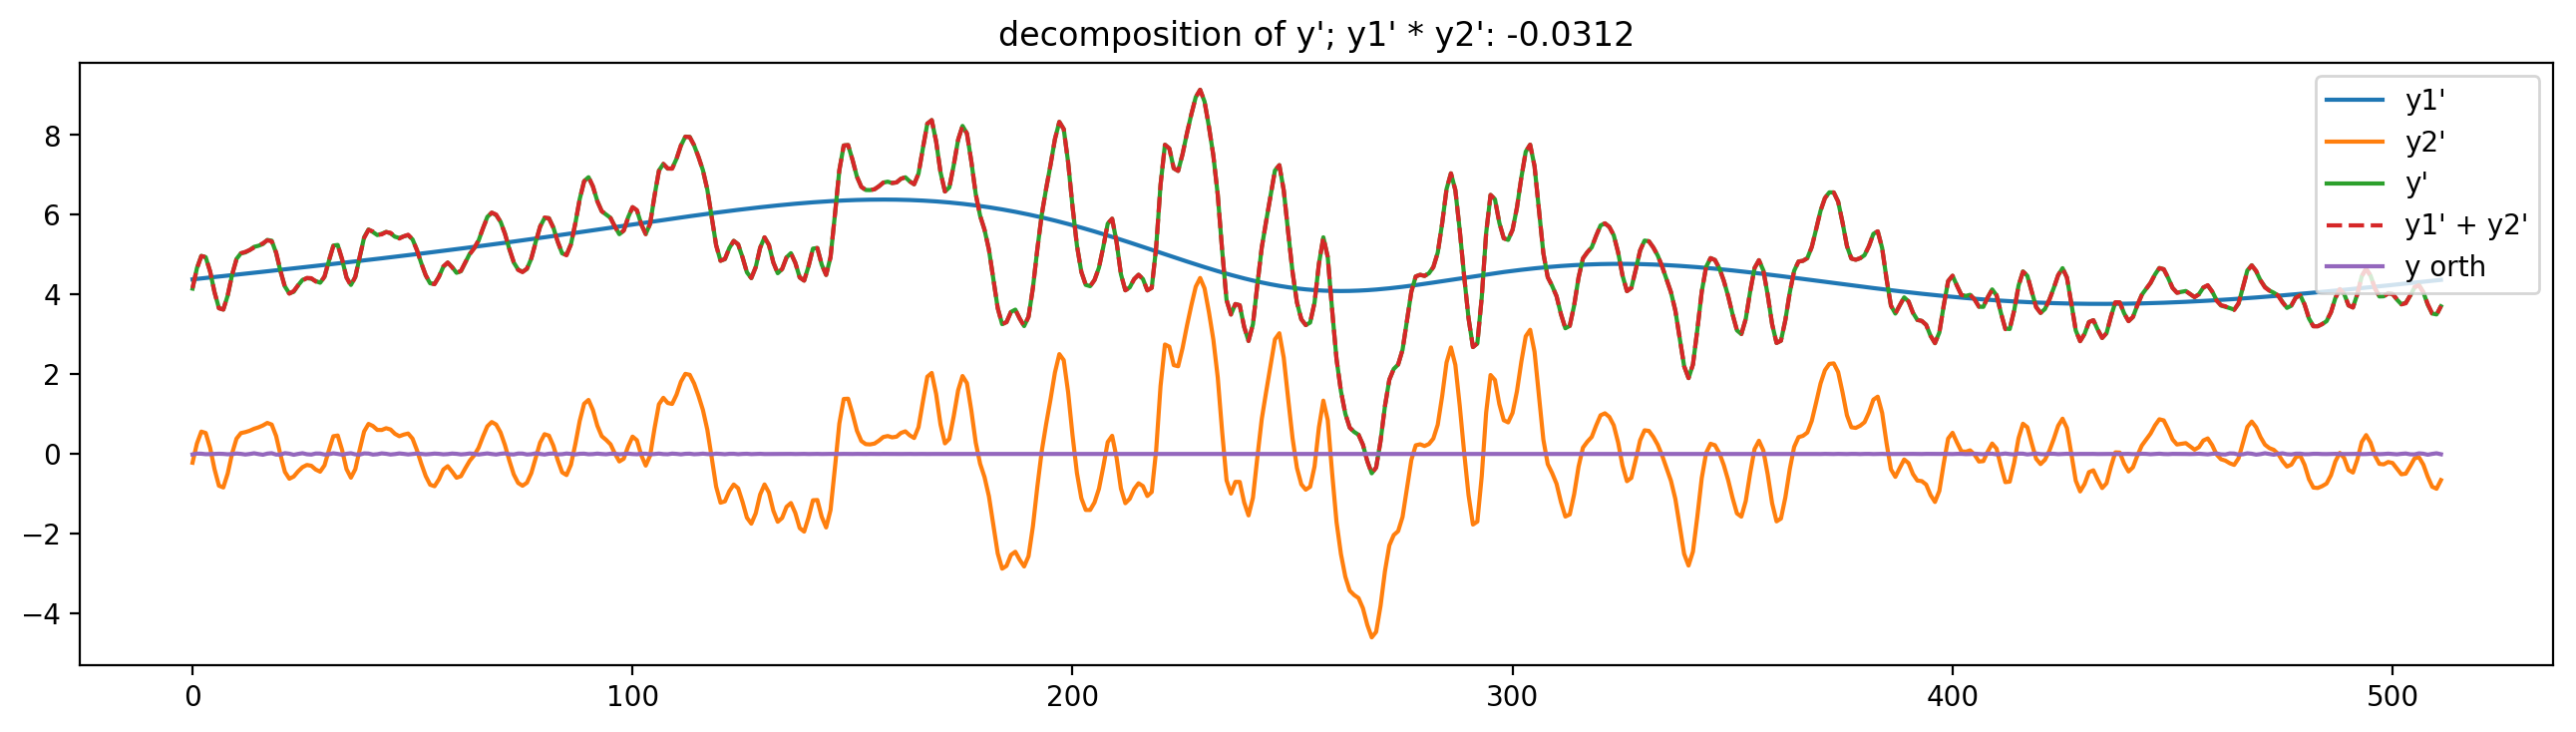

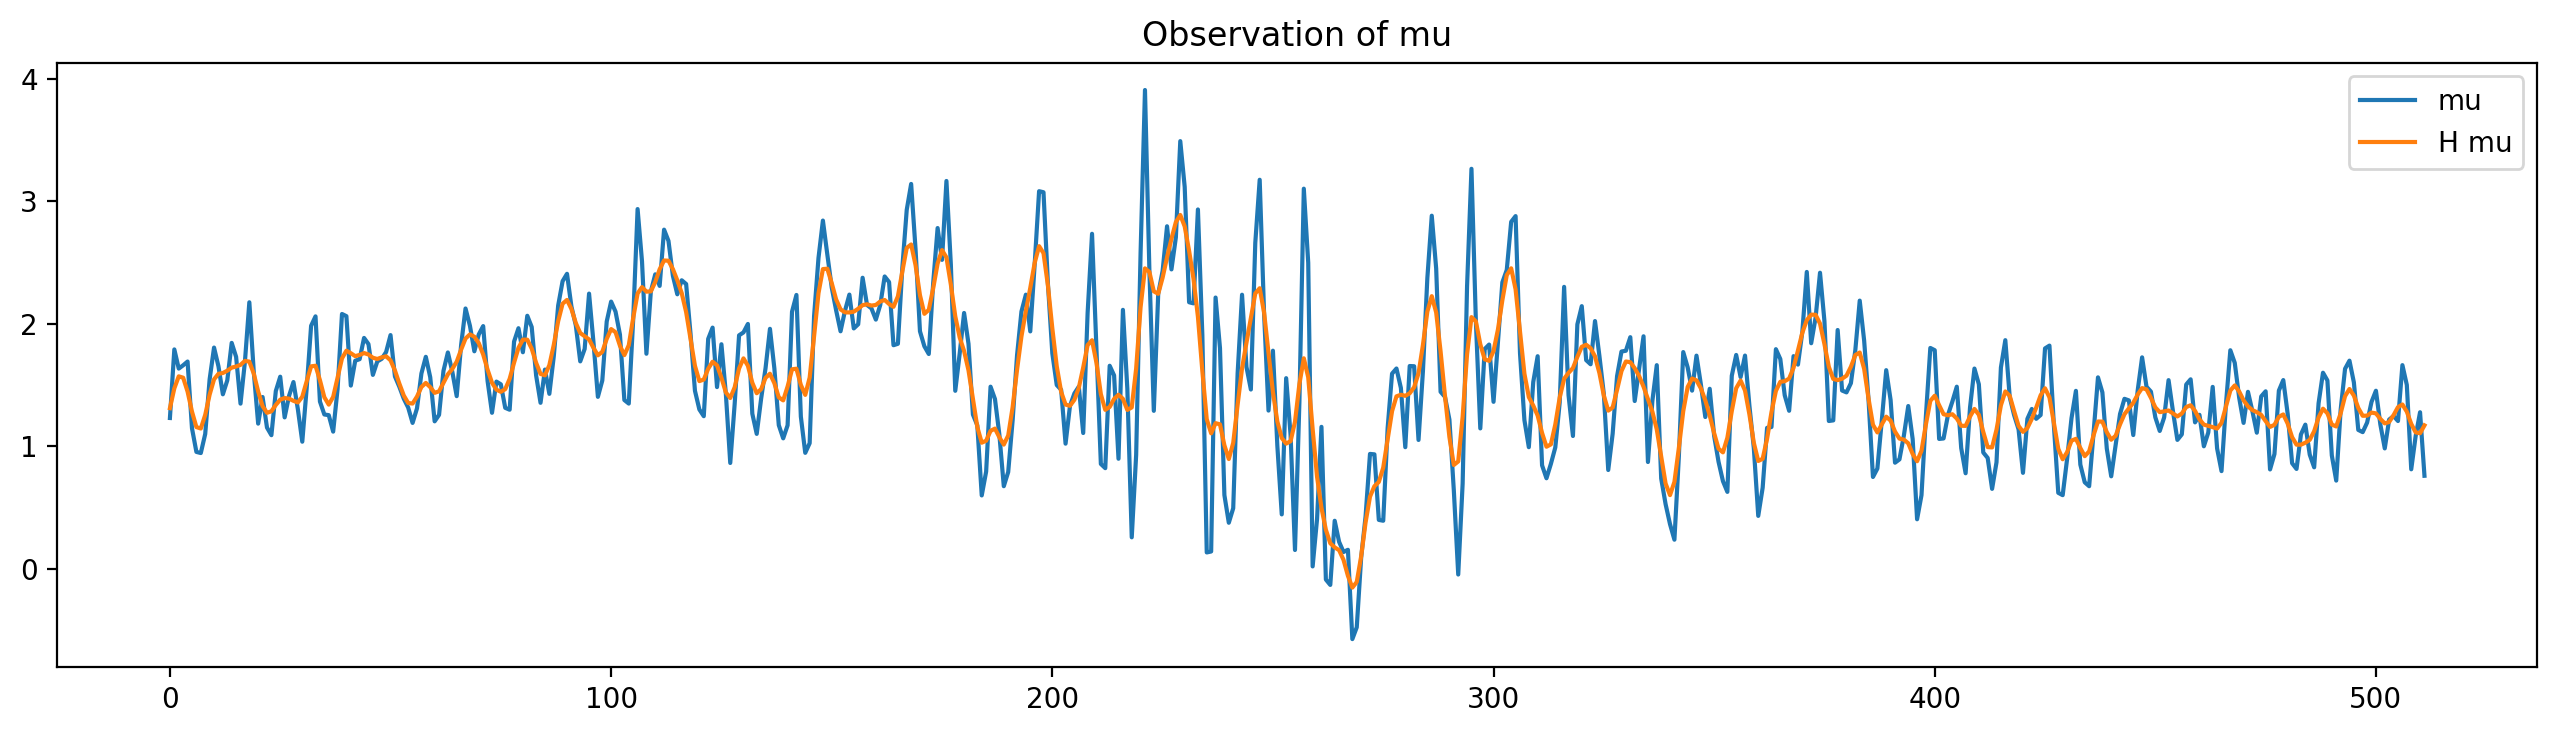

In [20]:
# print(a_mu.T @ this @ a_mu)
mu1p = np.diag(Lam1**(-1/2)) @ Q1.T @ a_mu
mu2p = np.diag(Lam2**(-1/2)) @ Q2.T @ a_mu

yp = R_inv_sqrtz @ Hz @ a_mu
y1p = Tp1 @ mu1p
y2p = Tp2 @ mu2p
y_orth = R_inv_sqrtz @ Hz @ Proj @ a_mu

prodmu = (Q1 @ Q1.T @ a_mu).T @ Q2 @ Q2.T @ a_mu
prody = (y1p[None, :] @ y2p[:, None]).item()


figsize = plt.figaspect(1/4)
plt.figure(dpi=200, figsize=figsize)
plt.plot(a_mu, alpha=0.5)
plt.plot(Q1 @ Q1.T @ a_mu, ':', alpha=0.5)
plt.plot(Q2 @ Q2.T @ a_mu, ':', alpha=0.5)
plt.legend(['mu', 'mu1', 'mu2'])
plt.title(f'mu decomposed; mu1 * mu2: {prodmu:0.3}')

plt.figure(dpi=200, figsize=figsize)
plt.plot(y1p)
plt.plot(y2p)
plt.plot(yp)
plt.plot(y1p + y2p, '--')
plt.plot(y_orth)
plt.title(f'decomposition of y\'; y1\' * y2\': {prody:0.3}')
plt.legend(['y1\'', 'y2\'', 'y\'', 'y1\' + y2\'', 'y orth'])

plt.figure(dpi=200, figsize=figsize)
plt.plot(a_mu)
plt.plot(Hz @ a_mu)
plt.title('Observation of mu')
plt.legend(['mu', 'H mu'])



In [21]:
y1 = Ty1 @ Hz @ a_mu
y2 = Ty2 @ Hz @ a_mu

mu1 = Tx1 @ a_mu
mu2 = Tx2 @ a_mu
mu_orth = Proj @ a_mu

Text(0.5, 1.0, 'difference')

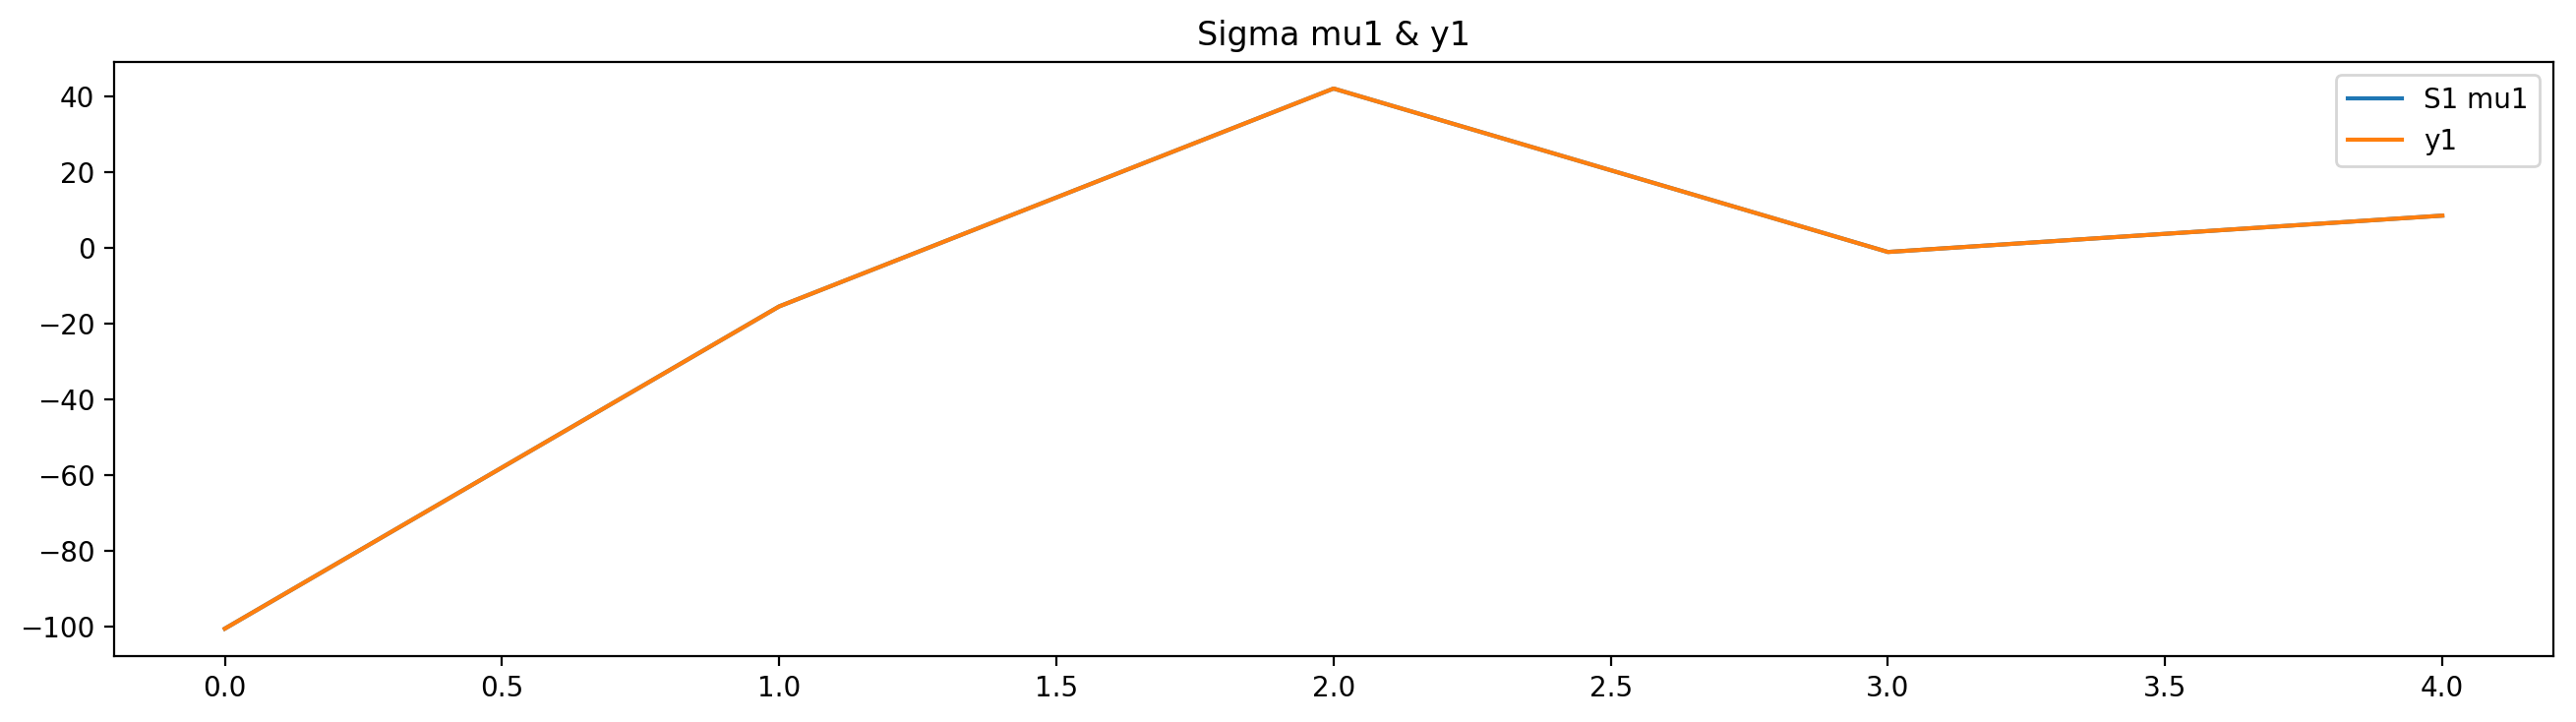

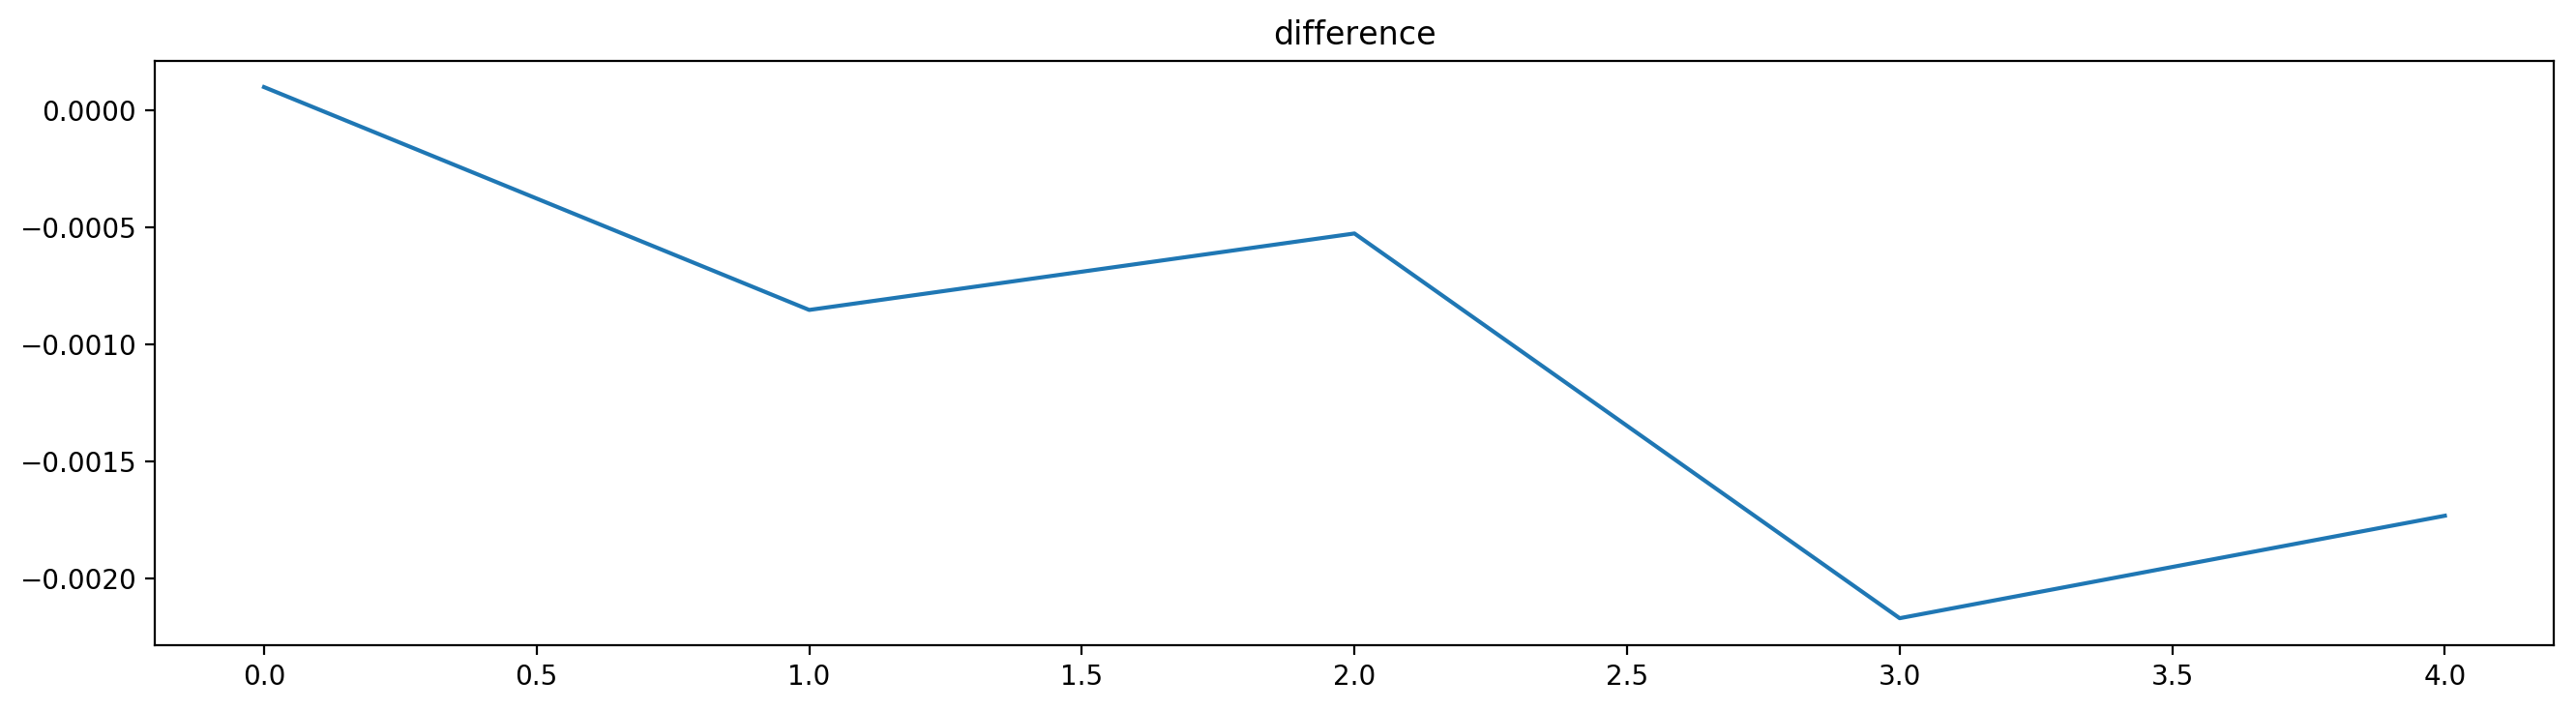

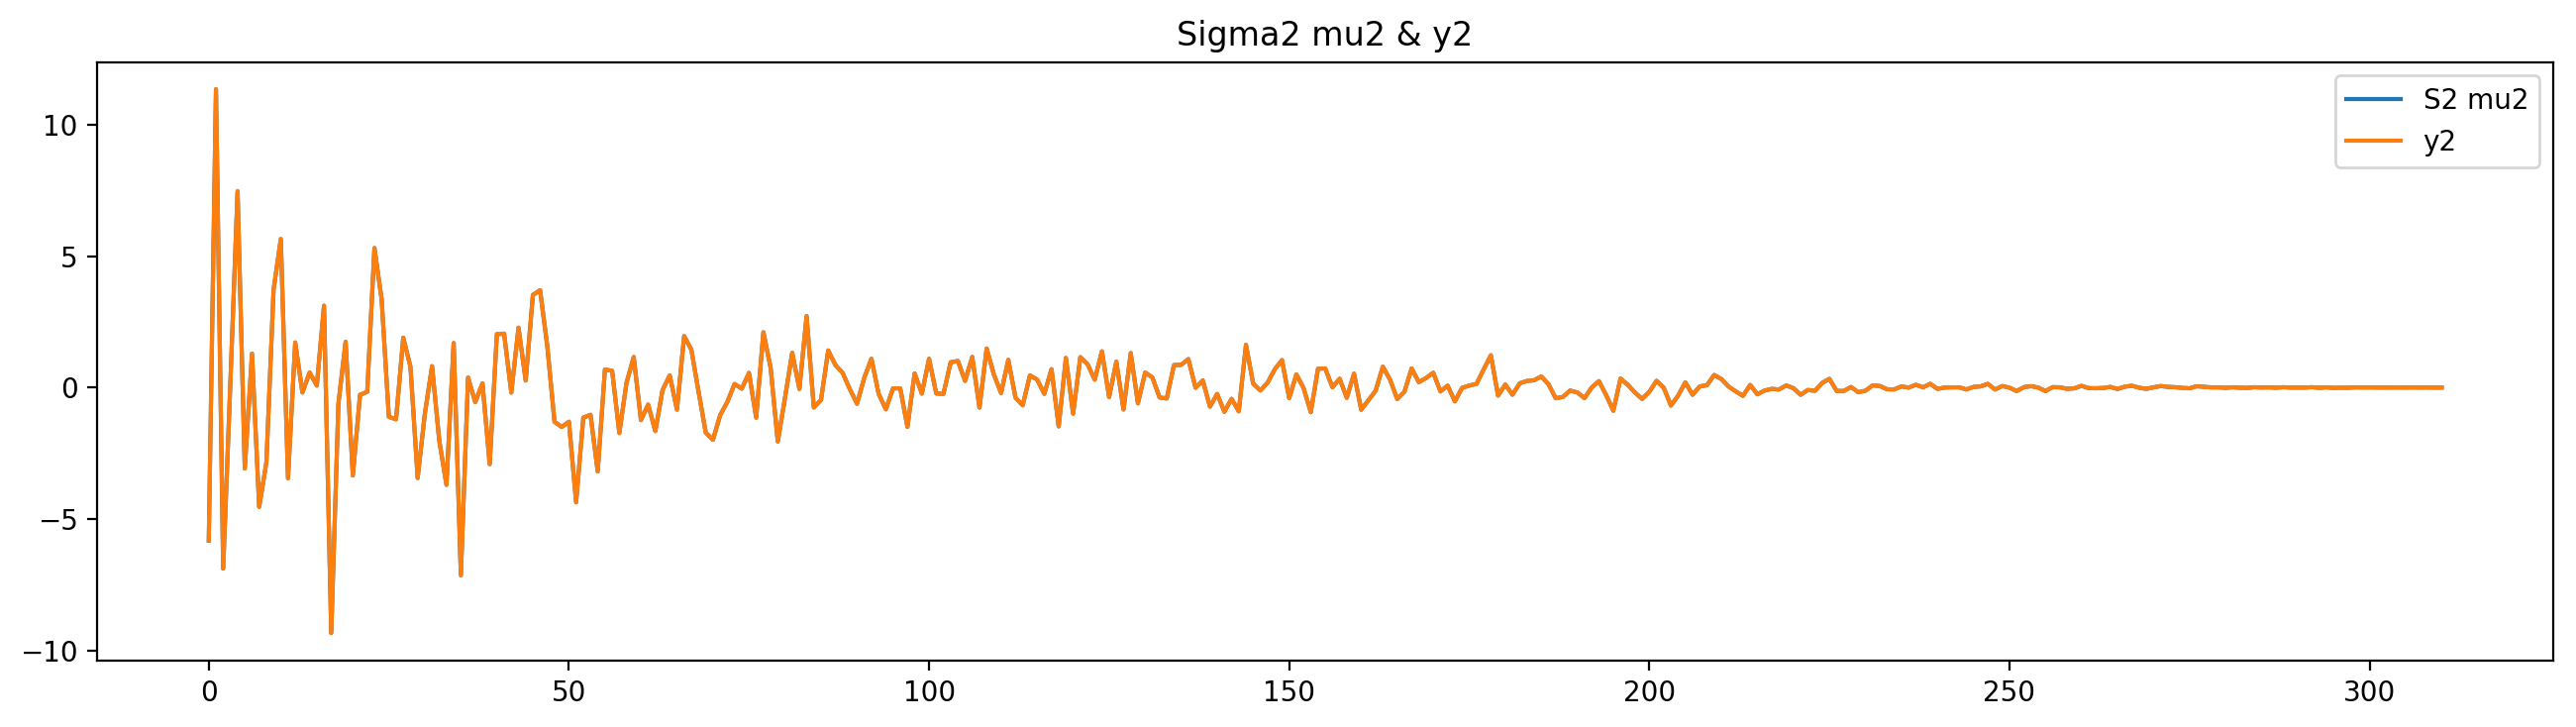

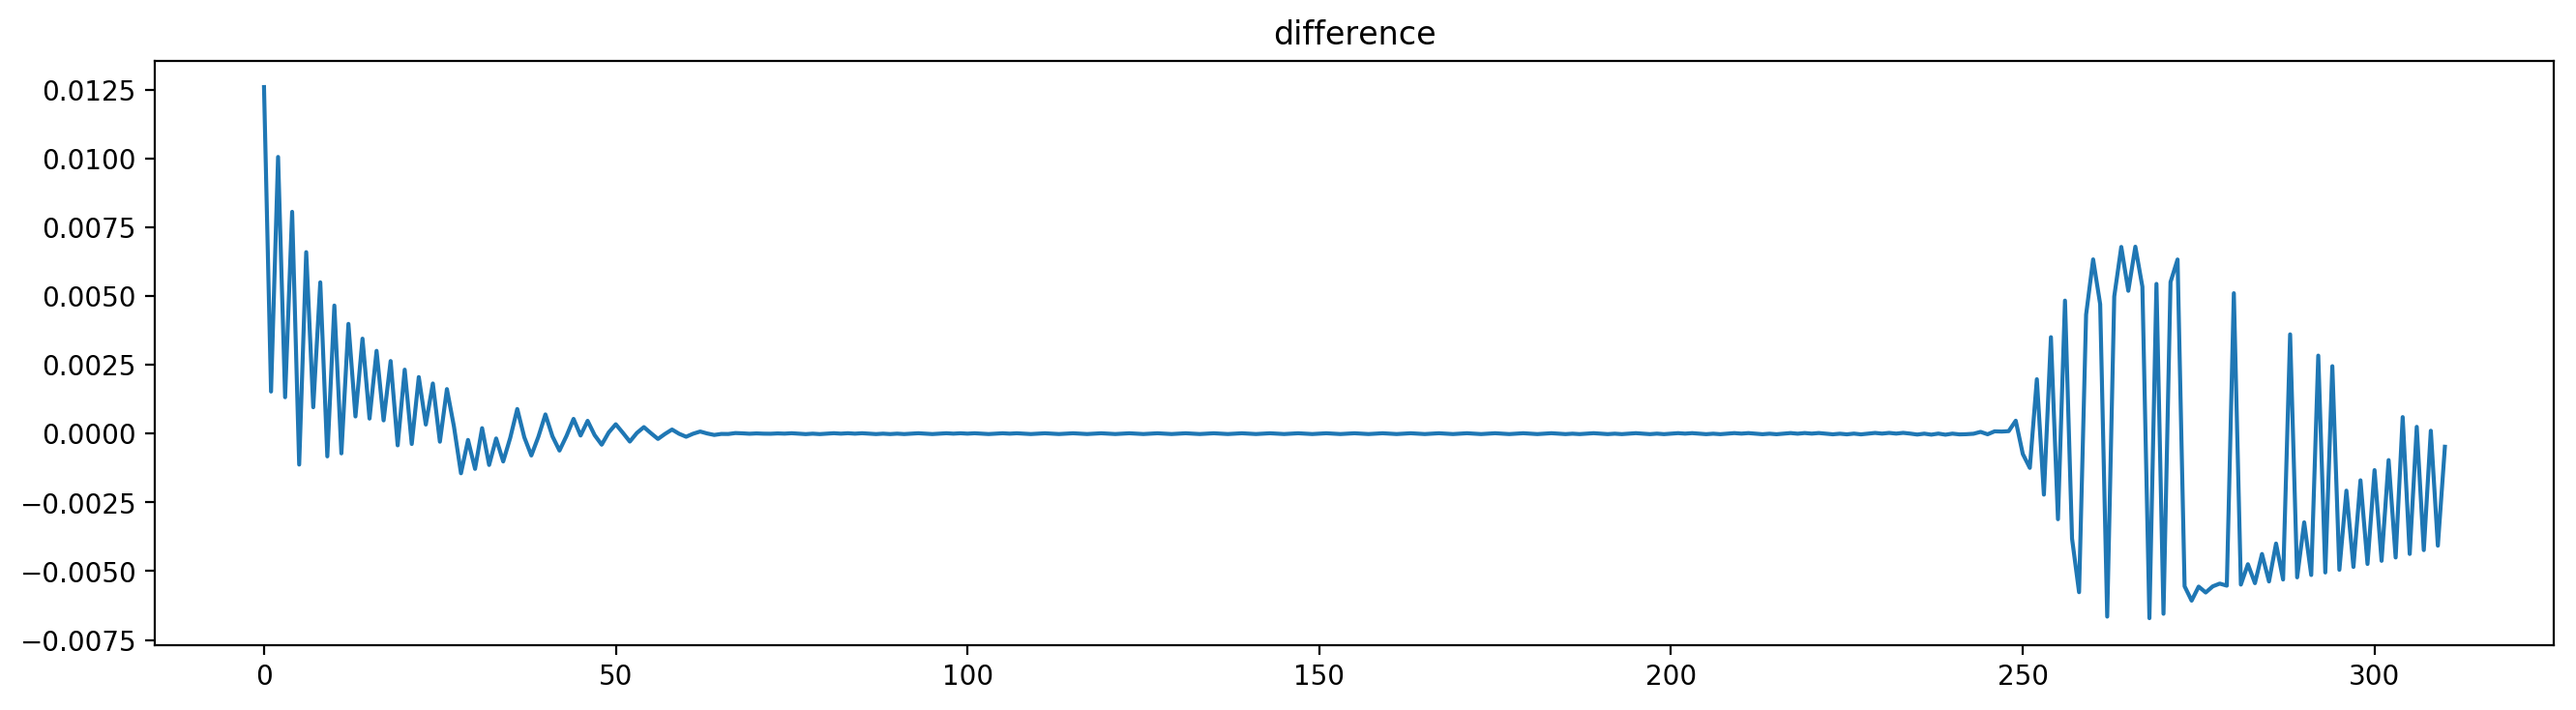

In [22]:
plt.figure(dpi=200, figsize=figsize)
plt.plot(S1 @ mu1)
plt.plot(y1)
plt.title('Sigma mu1 & y1')
plt.legend(['S1 mu1', 'y1'])

plt.figure(dpi=200, figsize=figsize)
plt.plot(y1 - S1 @ mu1)
plt.title('difference')

plt.figure(dpi=200, figsize=figsize)
plt.plot(S2 @ mu2)
plt.plot(y2)
plt.title('Sigma2 mu2 & y2')
plt.legend(['S2 mu2', 'y2'])

plt.figure(dpi=200, figsize=figsize)
plt.plot(y2 - S2 @ mu2)
plt.title('difference')

Text(0.5, 1.0, 'Difference')

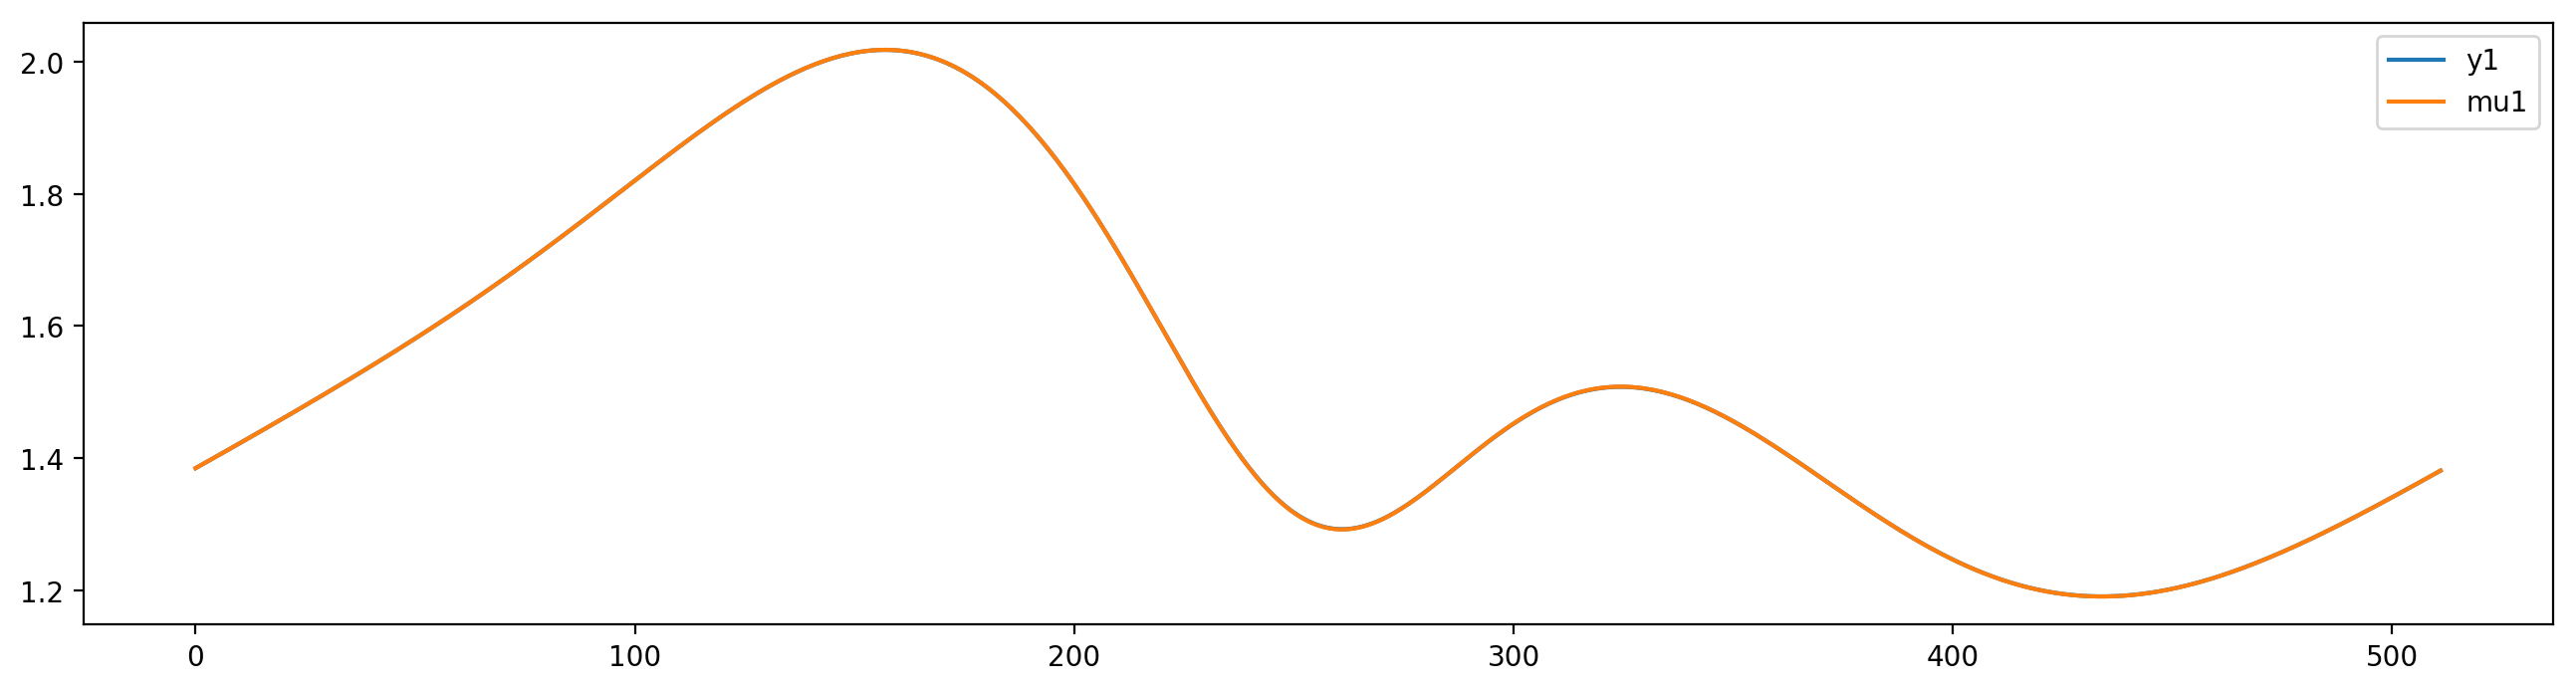

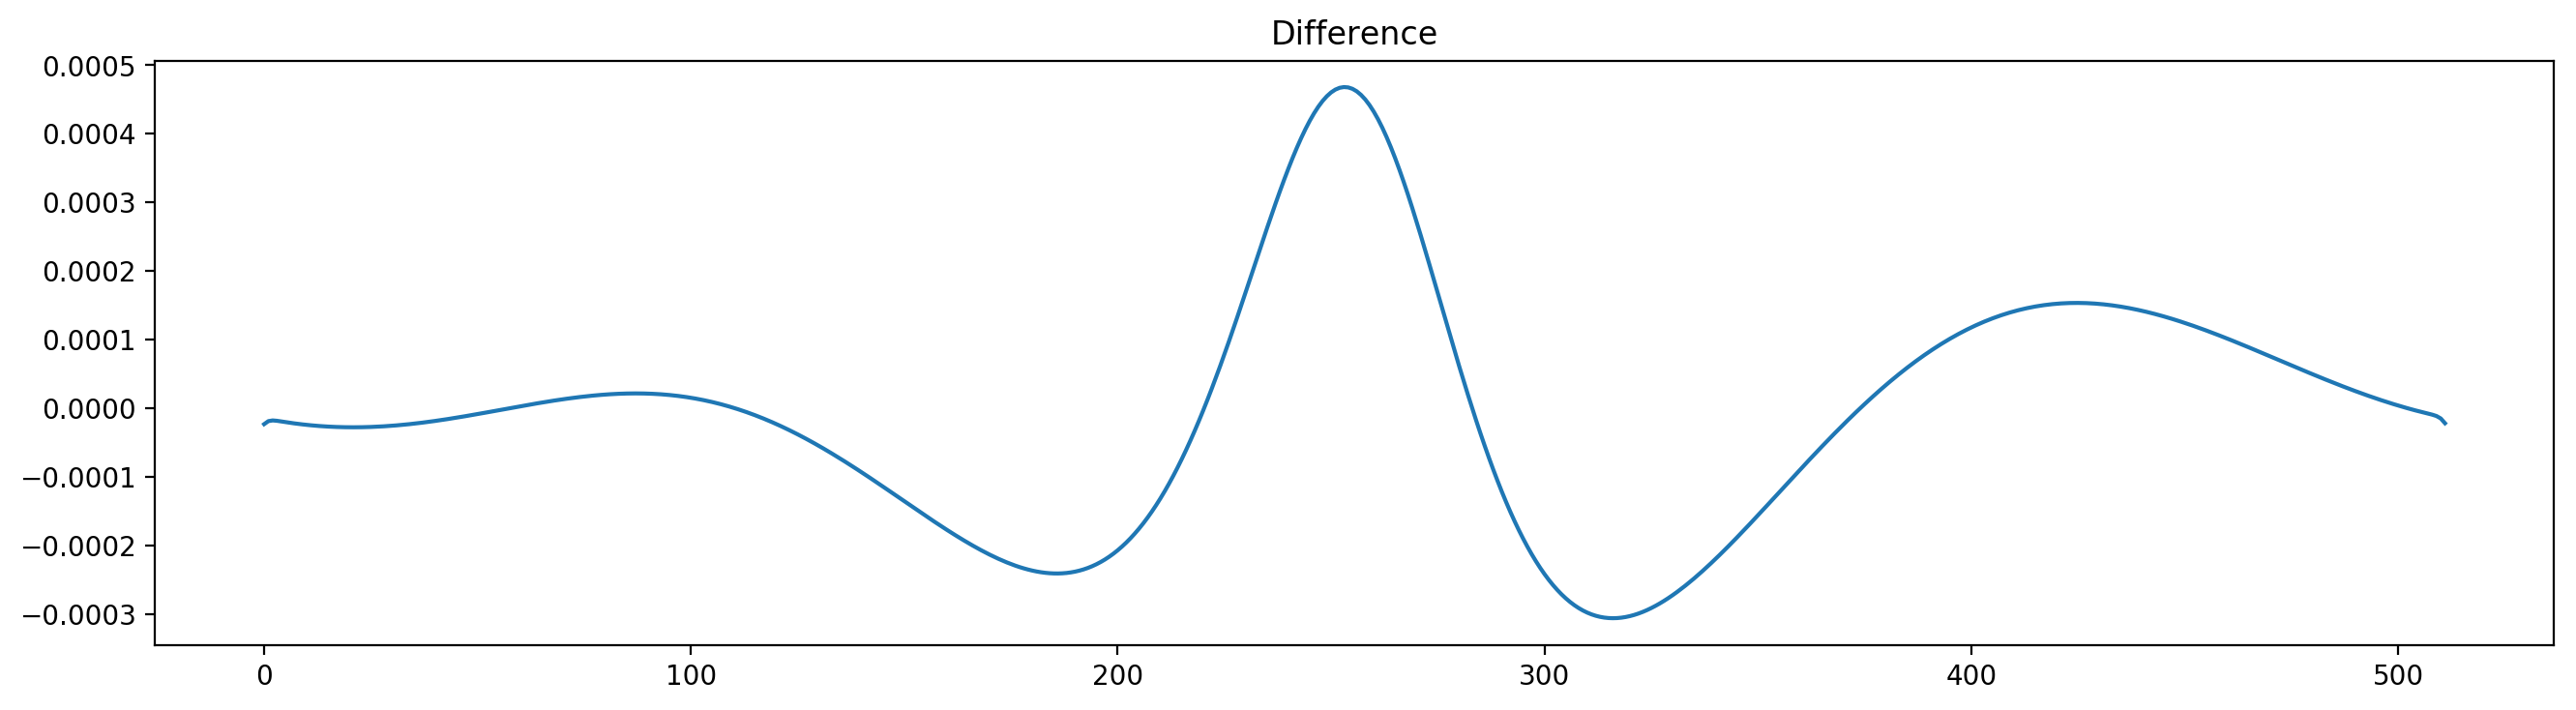

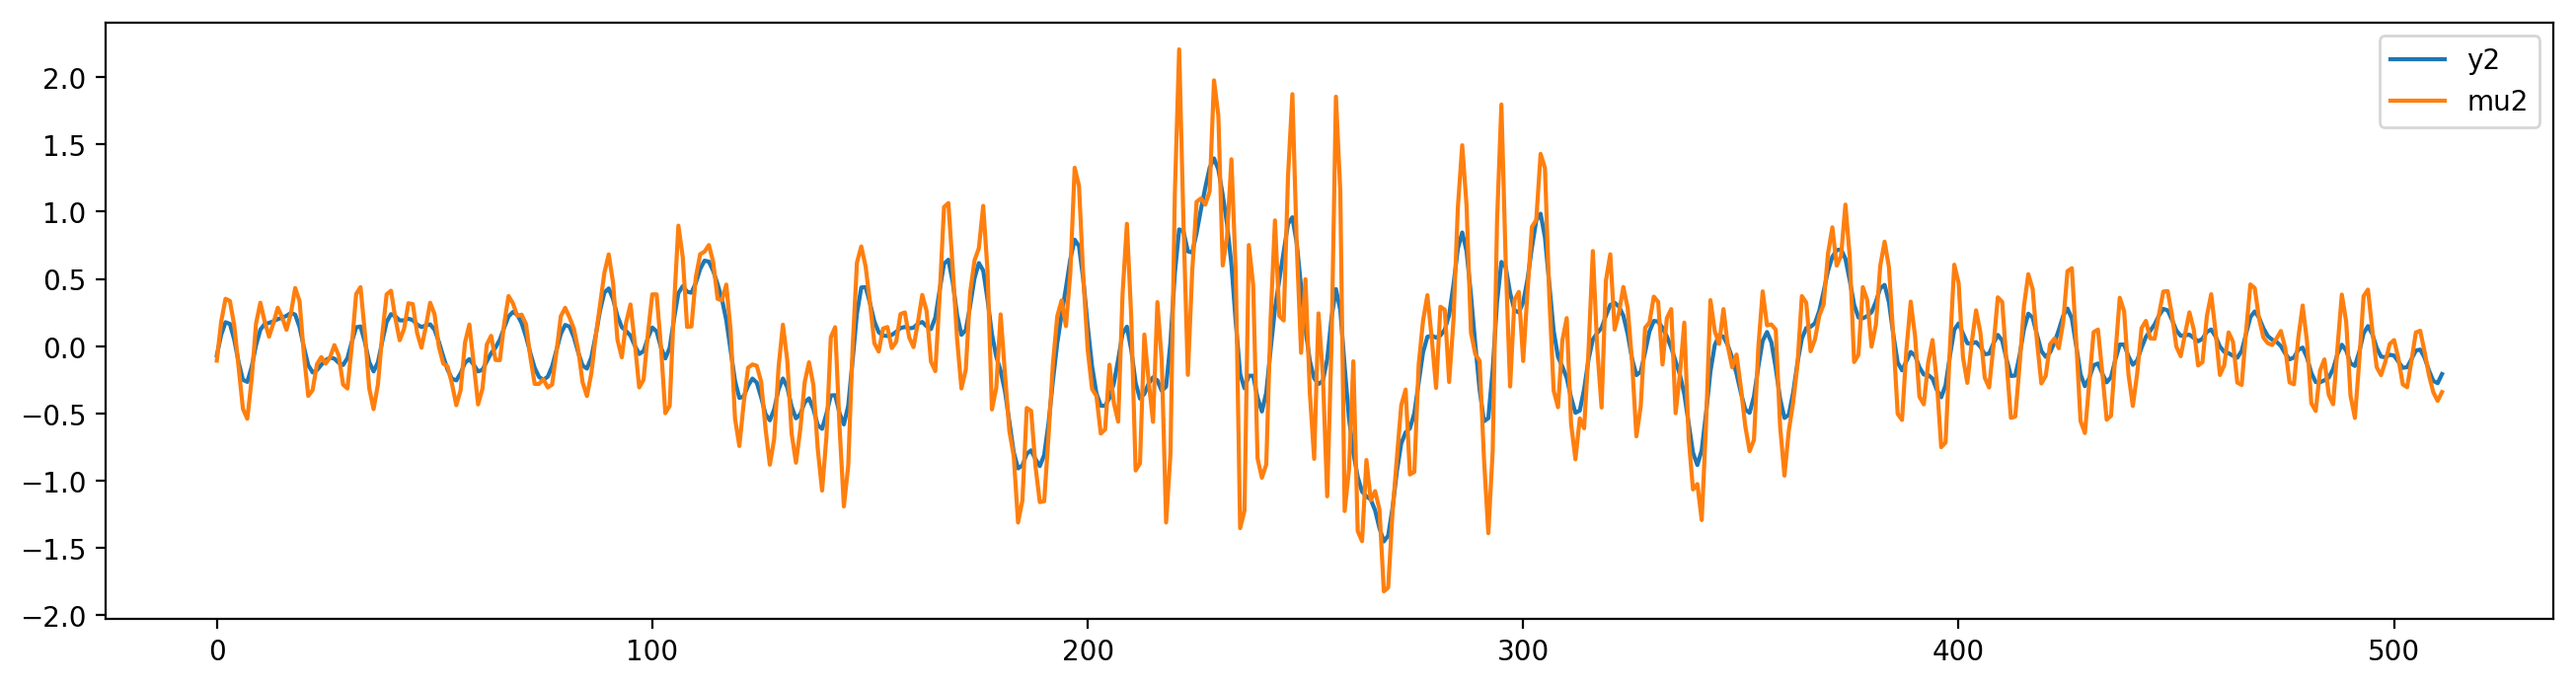

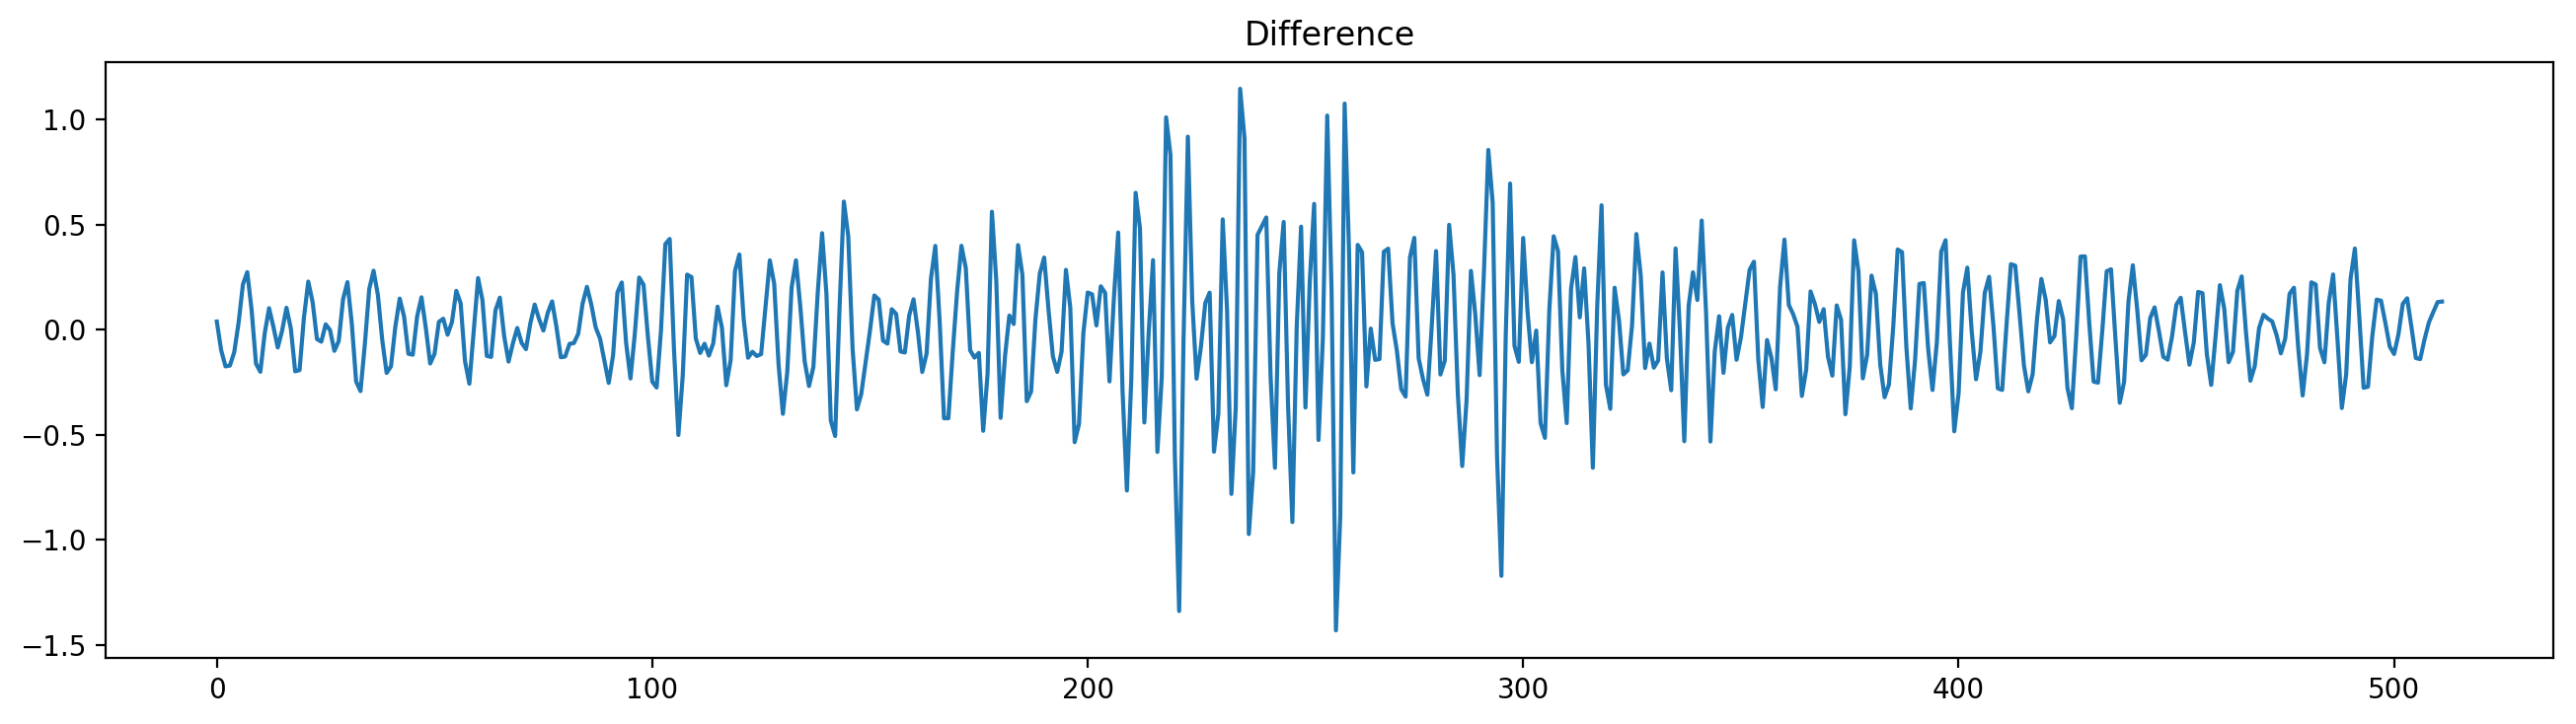

In [23]:
plt.figure(dpi=200, figsize=figsize)
plt.plot(Ty1R @ y1)
plt.plot(Tx1R @ mu1)
plt.legend(['y1', 'mu1'])

plt.figure(dpi=200, figsize=figsize)
plt.plot(Ty1R @ y1 - Tx1R @ mu1)
plt.title('Difference')

plt.figure(dpi=200, figsize=figsize)
plt.plot(Ty2R @ y2)
plt.plot(Tx2R @ mu2)
plt.legend(['y2', 'mu2'])

plt.figure(dpi=200, figsize=figsize)
plt.plot(Ty2R @ y2 - Tx2R @ mu2)
plt.title('Difference')